## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
# import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


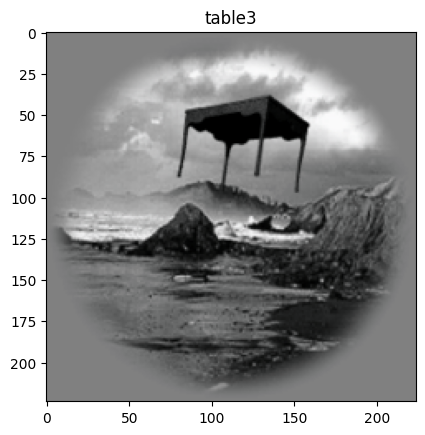

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

(2592,)


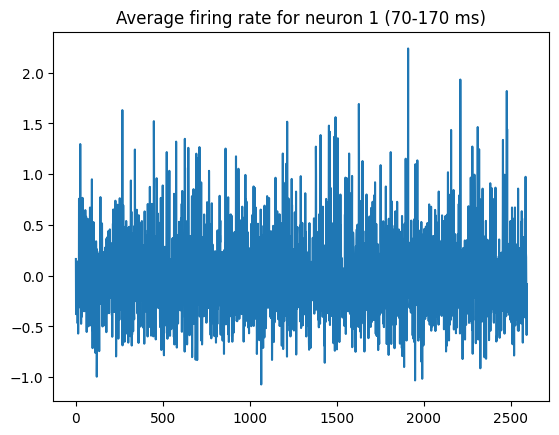

In [6]:
neuron_idx = 1

print(spikes_train[:,neuron_idx].shape)
plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
print(f"Stimulus shapes : {stimulus_train.shape, stimulus_test.shape, stimulus_val.shape}")
print(f"Objects shapes : {len(objects_train), len(objects_test), len(objects_val)}")
print(f"Spikes shapes : {spikes_train.shape, spikes_val.shape}")
x_train = stimulus_train.reshape((stimulus_train.shape[0], -1))
x_val = stimulus_val.reshape((stimulus_val.shape[0], -1))
print(f"Training : X shape = {x_train.shape}, Y shape = {spikes_train.shape}")

Stimulus shapes : ((2592, 3, 224, 224), (320, 3, 224, 224), (288, 3, 224, 224))
Objects shapes : (2592, 320, 288)
Spikes shapes : ((2592, 168), (288, 168))
Training : X shape = (2592, 150528), Y shape = (2592, 168)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

/home/yann/.brainlike/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.05083e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


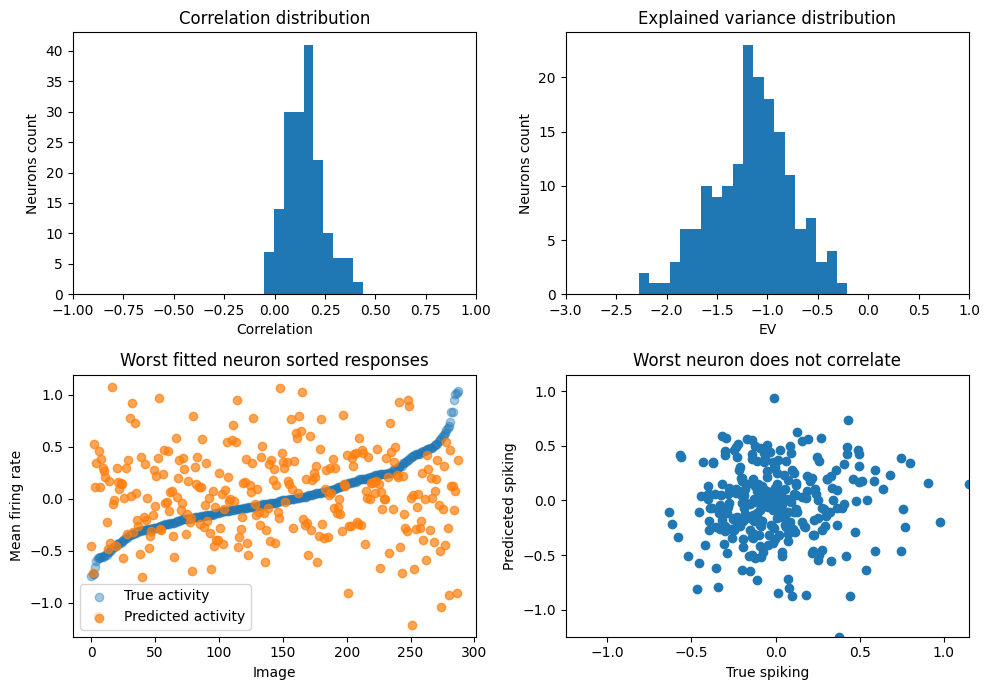

In [8]:
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Ridge

reg = Ridge()
reg.fit(x_train, spikes_train)
y_pred = reg.predict(x_val)

# sklearn formula : ev = 1 - var(y_true - y_pred)/var(y_true)
ev_scores = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
corr_scores = [np.corrcoef(spikes_val[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])]

f, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].set_title('Correlation distribution')
axs[0,0].hist(corr_scores, bins=10)
axs[0,0].set_xlabel('Correlation')
axs[0,0].set_ylabel('Neurons count')
axs[0,0].set_xlim((-1, 1))

axs[0,1].set_title('Explained variance distribution')
axs[0,1].hist(ev_scores, bins=20)
axs[0,1].set_xlabel('EV')
axs[0,1].set_ylabel('Neurons count')
axs[0,1].set_xlim((-3, 1))

worst = np.argmin(corr_scores)

axs[1,0].set_title('Worst fitted neuron sorted responses')
worst_neuron = spikes_val[:, worst]
argsorts_worst = np.argsort(worst_neuron)
images = np.arange(len(worst_neuron))
axs[1,0].scatter(images, worst_neuron[argsorts_worst], label='True activity', alpha=0.4)
axs[1,0].scatter(images, y_pred[argsorts_worst,worst], label='Predicted activity', alpha=0.7)
axs[1,0].set_xlabel('Image')
axs[1,0].set_ylabel('Mean firing rate')
axs[1,0].legend()

axs[1,1].set_title('Worst neuron does not correlate')
x_min, x_max = np.min((spikes_val[:,37], y_pred[:,37])), np.max((spikes_val[:,37], y_pred[:,37]))
axs[1,1].scatter(spikes_val[:,37], y_pred[:,37])
axs[1,1].set_xlim(x_min, x_max)
axs[1,1].set_ylim(x_min, x_max)
axs[1,1].set_xlabel('True spiking')
axs[1,1].set_ylabel('Prediceted spiking')

plt.tight_layout()
plt.show()

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [9]:
#### Here your code
from sklearn.decomposition import PCA

pca = PCA(1000)
pcs_train = pca.fit_transform(x_train)
pcs_val = pca.transform(x_val)

print(f"Reduced x are of shape = {pcs_train.shape} and {pcs_val.shape}")

Reduced x are of shape = (2592, 1000) and (288, 1000)


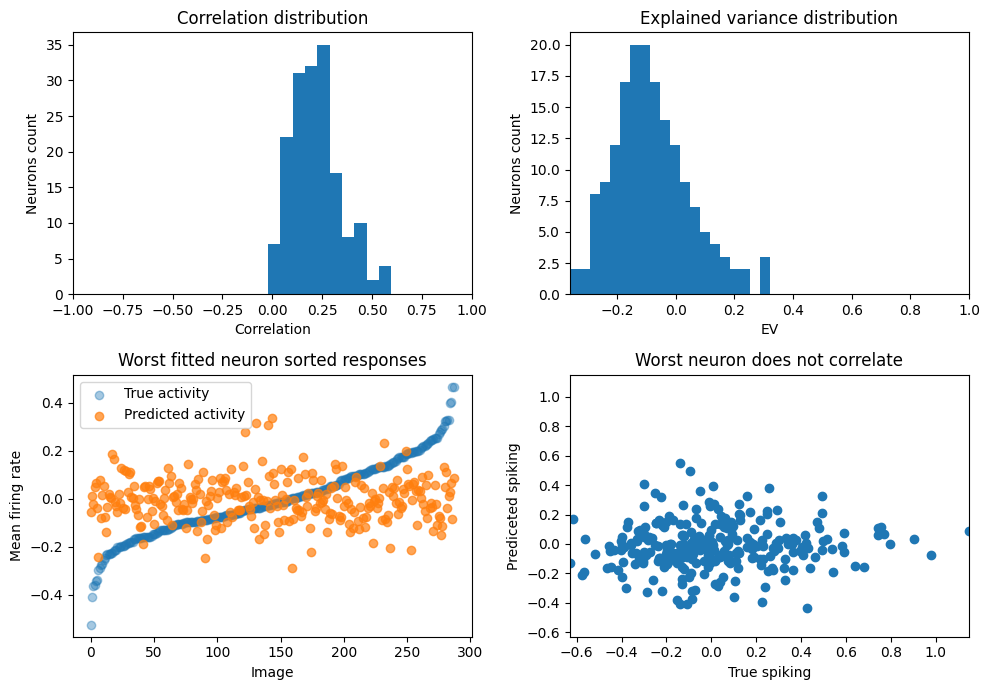

In [10]:
reg = Ridge()
reg.fit(pcs_train, spikes_train)
y_pred = reg.predict(pcs_val)

# sklearn formula : ev = 1 - var(y_true - y_pred)/var(y_true)
ev_scores = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
corr_scores = [np.corrcoef(spikes_val[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])]

f, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].set_title('Correlation distribution')
axs[0,0].hist(corr_scores, bins=10)
axs[0,0].set_xlabel('Correlation')
axs[0,0].set_ylabel('Neurons count')
axs[0,0].set_xlim((-1, 1))

axs[0,1].set_title('Explained variance distribution')
axs[0,1].hist(ev_scores, bins=20)
axs[0,1].set_xlabel('EV')
axs[0,1].set_ylabel('Neurons count')
axs[0,1].set_xlim((min(ev_scores), 1))

worst = np.argmin(corr_scores)

axs[1,0].set_title('Worst fitted neuron sorted responses')
worst_neuron = spikes_val[:, worst]
argsorts_worst = np.argsort(worst_neuron)
images = np.arange(len(worst_neuron))
axs[1,0].scatter(images, worst_neuron[argsorts_worst], label='True activity', alpha=0.4)
axs[1,0].scatter(images, y_pred[argsorts_worst,worst], label='Predicted activity', alpha=0.7)
axs[1,0].set_xlabel('Image')
axs[1,0].set_ylabel('Mean firing rate')
axs[1,0].legend()

axs[1,1].set_title('Worst neuron does not correlate')
x_min, x_max = np.min((spikes_val[:,37], y_pred[:,37])), np.max((spikes_val[:,37], y_pred[:,37]))
axs[1,1].scatter(spikes_val[:,37], y_pred[:,37])
axs[1,1].set_xlim(x_min, x_max)
axs[1,1].set_ylim(x_min, x_max)
axs[1,1].set_xlabel('True spiking')
axs[1,1].set_ylabel('Prediceted spiking')

plt.tight_layout()
plt.show()

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

CROSS-VALIDATION :


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


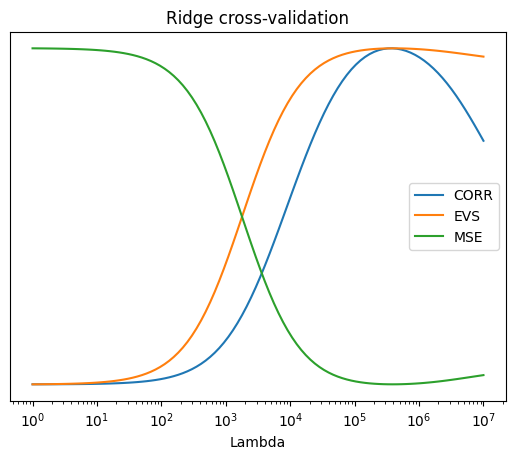

Best lambda = 385353


In [11]:
#### Here your code
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, explained_variance_score
from tqdm import tqdm

lbds = np.logspace(0, 7, 100)
skf = StratifiedKFold()

evs, corrs, mses = [], [], []

print("CROSS-VALIDATION :")
for i in tqdm(range(len(lbds))):

    ev_lbd, corr_lbd, mse_lbd = 0, 0, 0

    for j, (tr_idx, val_idx) in enumerate(skf.split(x_train, objects_train)):
        # Use PC for better fit
        x_tr_fold = pcs_train[tr_idx]
        x_val_fold = pcs_train[val_idx]
        y_tr_fold = spikes_train[tr_idx]
        y_val_fold = spikes_train[val_idx]

        reg_fold = Ridge(lbds[i])
        reg_fold.fit(x_tr_fold, y_tr_fold)
        y_pred_fold = reg_fold.predict(x_val_fold)

        # Fold metrics are explained variance, mean neuron correlation and mse 
        ev_lbd += explained_variance_score(y_val_fold, y_pred_fold)
        corr_lbd += np.mean([np.corrcoef(y_val_fold[:,neuron], y_pred_fold[:,neuron])[0,1] for neuron in range(y_pred_fold.shape[1])])
        mse_lbd += mean_squared_error(y_val_fold, y_pred_fold)

    evs.append(ev_lbd/5)
    corrs.append(corr_lbd/5)
    mses.append(mse_lbd/5)

norm = lambda x: (x-min(x))/(max(x)-min(x))

plt.plot(lbds, norm(corrs), label='CORR')
plt.plot(lbds, norm(evs), label='EVS')
plt.plot(lbds, norm(mses), label='MSE')
plt.title("Ridge cross-validation")
plt.xlabel("Lambda")
plt.legend()
plt.xscale('log')
plt.yticks([])
plt.show()
print(f"Best lambda = {lbds[np.argmin(mses)]:.0f}")

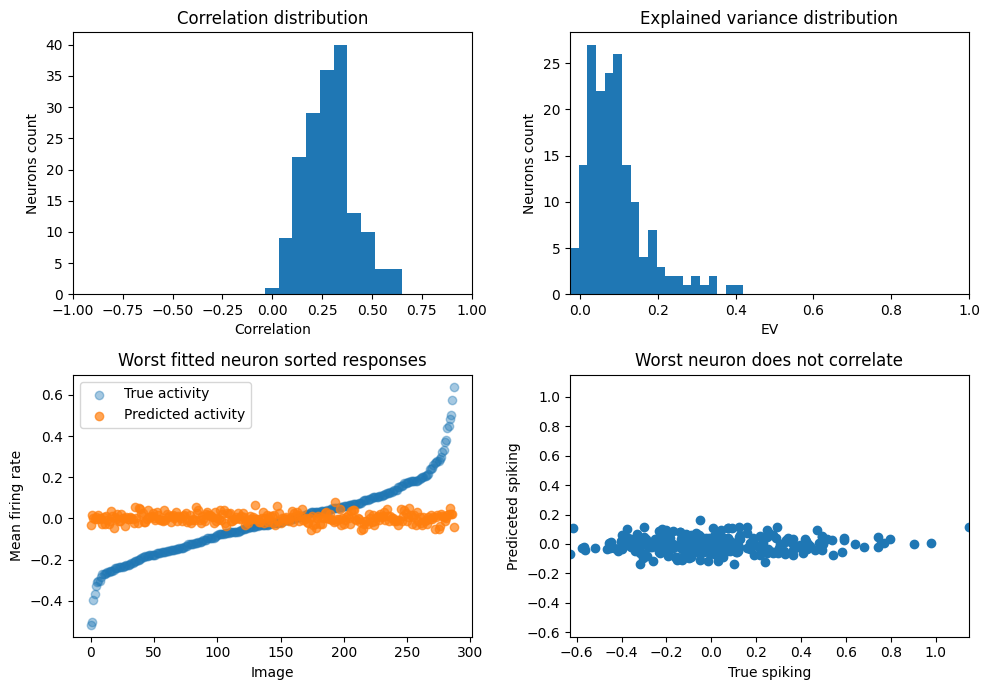

In [12]:
best_lbd = lbds[np.argmin(mses)]

reg = Ridge(best_lbd)
reg.fit(pcs_train, spikes_train)
y_pred = reg.predict(pcs_val)

ev_scores = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
corr_scores = [np.corrcoef(spikes_val[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])]

f, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].set_title('Correlation distribution')
axs[0,0].hist(corr_scores, bins=10)
axs[0,0].set_xlabel('Correlation')
axs[0,0].set_ylabel('Neurons count')
axs[0,0].set_xlim((-1, 1))

axs[0,1].set_title('Explained variance distribution')
axs[0,1].hist(ev_scores, bins=20)
axs[0,1].set_xlabel('EV')
axs[0,1].set_ylabel('Neurons count')
axs[0,1].set_xlim((min(ev_scores), 1))

worst = np.argmin(corr_scores)

axs[1,0].set_title('Worst fitted neuron sorted responses')
worst_neuron = spikes_val[:, worst]
argsorts_worst = np.argsort(worst_neuron)
images = np.arange(len(worst_neuron))
axs[1,0].scatter(images, worst_neuron[argsorts_worst], label='True activity', alpha=0.4)
axs[1,0].scatter(images, y_pred[argsorts_worst,worst], label='Predicted activity', alpha=0.7)
axs[1,0].set_xlabel('Image')
axs[1,0].set_ylabel('Mean firing rate')
axs[1,0].legend()

axs[1,1].set_title('Worst neuron does not correlate')
x_min, x_max = np.min((spikes_val[:,37], y_pred[:,37])), np.max((spikes_val[:,37], y_pred[:,37]))
axs[1,1].scatter(spikes_val[:,37], y_pred[:,37])
axs[1,1].set_xlim(x_min, x_max)
axs[1,1].set_ylim(x_min, x_max)
axs[1,1].set_xlabel('True spiking')
axs[1,1].set_ylabel('Prediceted spiking')

plt.tight_layout()
plt.show()

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [1]:
from brainlike.utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import explained_variance_score
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_data = 'brainlike/'
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
n_stimulus = stimulus_train.shape[0]

weights = ResNet50_Weights.DEFAULT # best available weights
model = resnet50(weights=weights)
model = model.to(device)
model.eval()

print(f"Computation on {device}.")
# preprocess = weights.transforms()

/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Computation on cuda.


In [2]:
return_nodes = ['conv1','layer1','layer2','layer3','layer4','avgpool']

activations_tr = []
activations_val = []

# imgs_tr = preprocess(torch.from_numpy(stimulus_train)).to(device)
# imgs_val = preprocess(torch.from_numpy(stimulus_val)).to(device)
imgs_tr = torch.from_numpy(stimulus_train).to(device)
imgs_val = torch.from_numpy(stimulus_val).to(device)

for return_node in return_nodes:
    
    with torch.no_grad():
        print(f"Extracting {return_node}:")
        
        # Forward training set
        extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
        activation_tr = extractor(imgs_tr)[return_node]
        activation_tr = activation_tr.flatten(1)

        print(f"   Fitting PCA on training set {tuple(activation_tr.shape)}...")
        U, S, V = torch.pca_lowrank(activation_tr, 1000) # components may be approximate
        activation_tr = activation_tr @ V
        activations_tr.append(activation_tr.cpu())
        print(f"   Extracted reduced training activations {tuple(activation_tr.shape)}.")
        del activation_tr, U, S

        # Forward validation set
        activation_val = extractor(imgs_val)[return_node]
        activation_val = activation_val.flatten(1) @ V
        activations_val.append(activation_val.cpu())
        print(f"   Extracted reduced validation activations {tuple(activation_val.shape)}.")
        del extractor, activation_val, V

        torch.cuda.empty_cache()

del model


Extracting conv1:


   Fitting PCA on training set (2592, 802816)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer1:
   Fitting PCA on training set (2592, 802816)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer2:
   Fitting PCA on training set (2592, 401408)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer3:
   Fitting PCA on training set (2592, 200704)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer4:
   Fitting PCA on training set (2592, 100352)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting avgpool:
   Fitting PCA on training set (2592, 2048)...
   Extracted reduced training activations (2592

In [4]:
random_activations_tr = []
random_activations_val = []

model = resnet50() # Random initialized network
model = model.to(device)
model.eval()

for return_node in return_nodes:
    
    with torch.no_grad():
        print(f"Extracting {return_node}:")
        
        # Forward training set
        extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
        random_activation_tr = extractor(imgs_tr)[return_node]
        random_activation_tr = random_activation_tr.flatten(1)

        print(f"   Fitting PCA on training set {tuple(random_activation_tr.shape)}...")
        U, S, V = torch.pca_lowrank(random_activation_tr, 1000) # components may be approximate
        random_activation_tr = random_activation_tr @ V
        random_activations_tr.append(random_activation_tr.cpu())
        print(f"   Extracted reduced training activations {tuple(random_activation_tr.shape)}.")
        del random_activation_tr, U, S

        # Forward validation set
        random_activation_val = extractor(imgs_val)[return_node]
        random_activation_val = random_activation_val.flatten(1) @ V
        random_activations_val.append(random_activation_val.cpu())
        print(f"   Extracted reduced validation activations {tuple(random_activation_val.shape)}.")
        del extractor, random_activation_val, V

        torch.cuda.empty_cache()


Extracting conv1:
   Fitting PCA on training set (2592, 802816)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer1:
   Fitting PCA on training set (2592, 802816)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer2:
   Fitting PCA on training set (2592, 401408)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer3:
   Fitting PCA on training set (2592, 200704)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting layer4:
   Fitting PCA on training set (2592, 100352)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).
Extracting avgpool:
   Fitting PCA on training set (2592, 2048)...
   Extracted reduced training

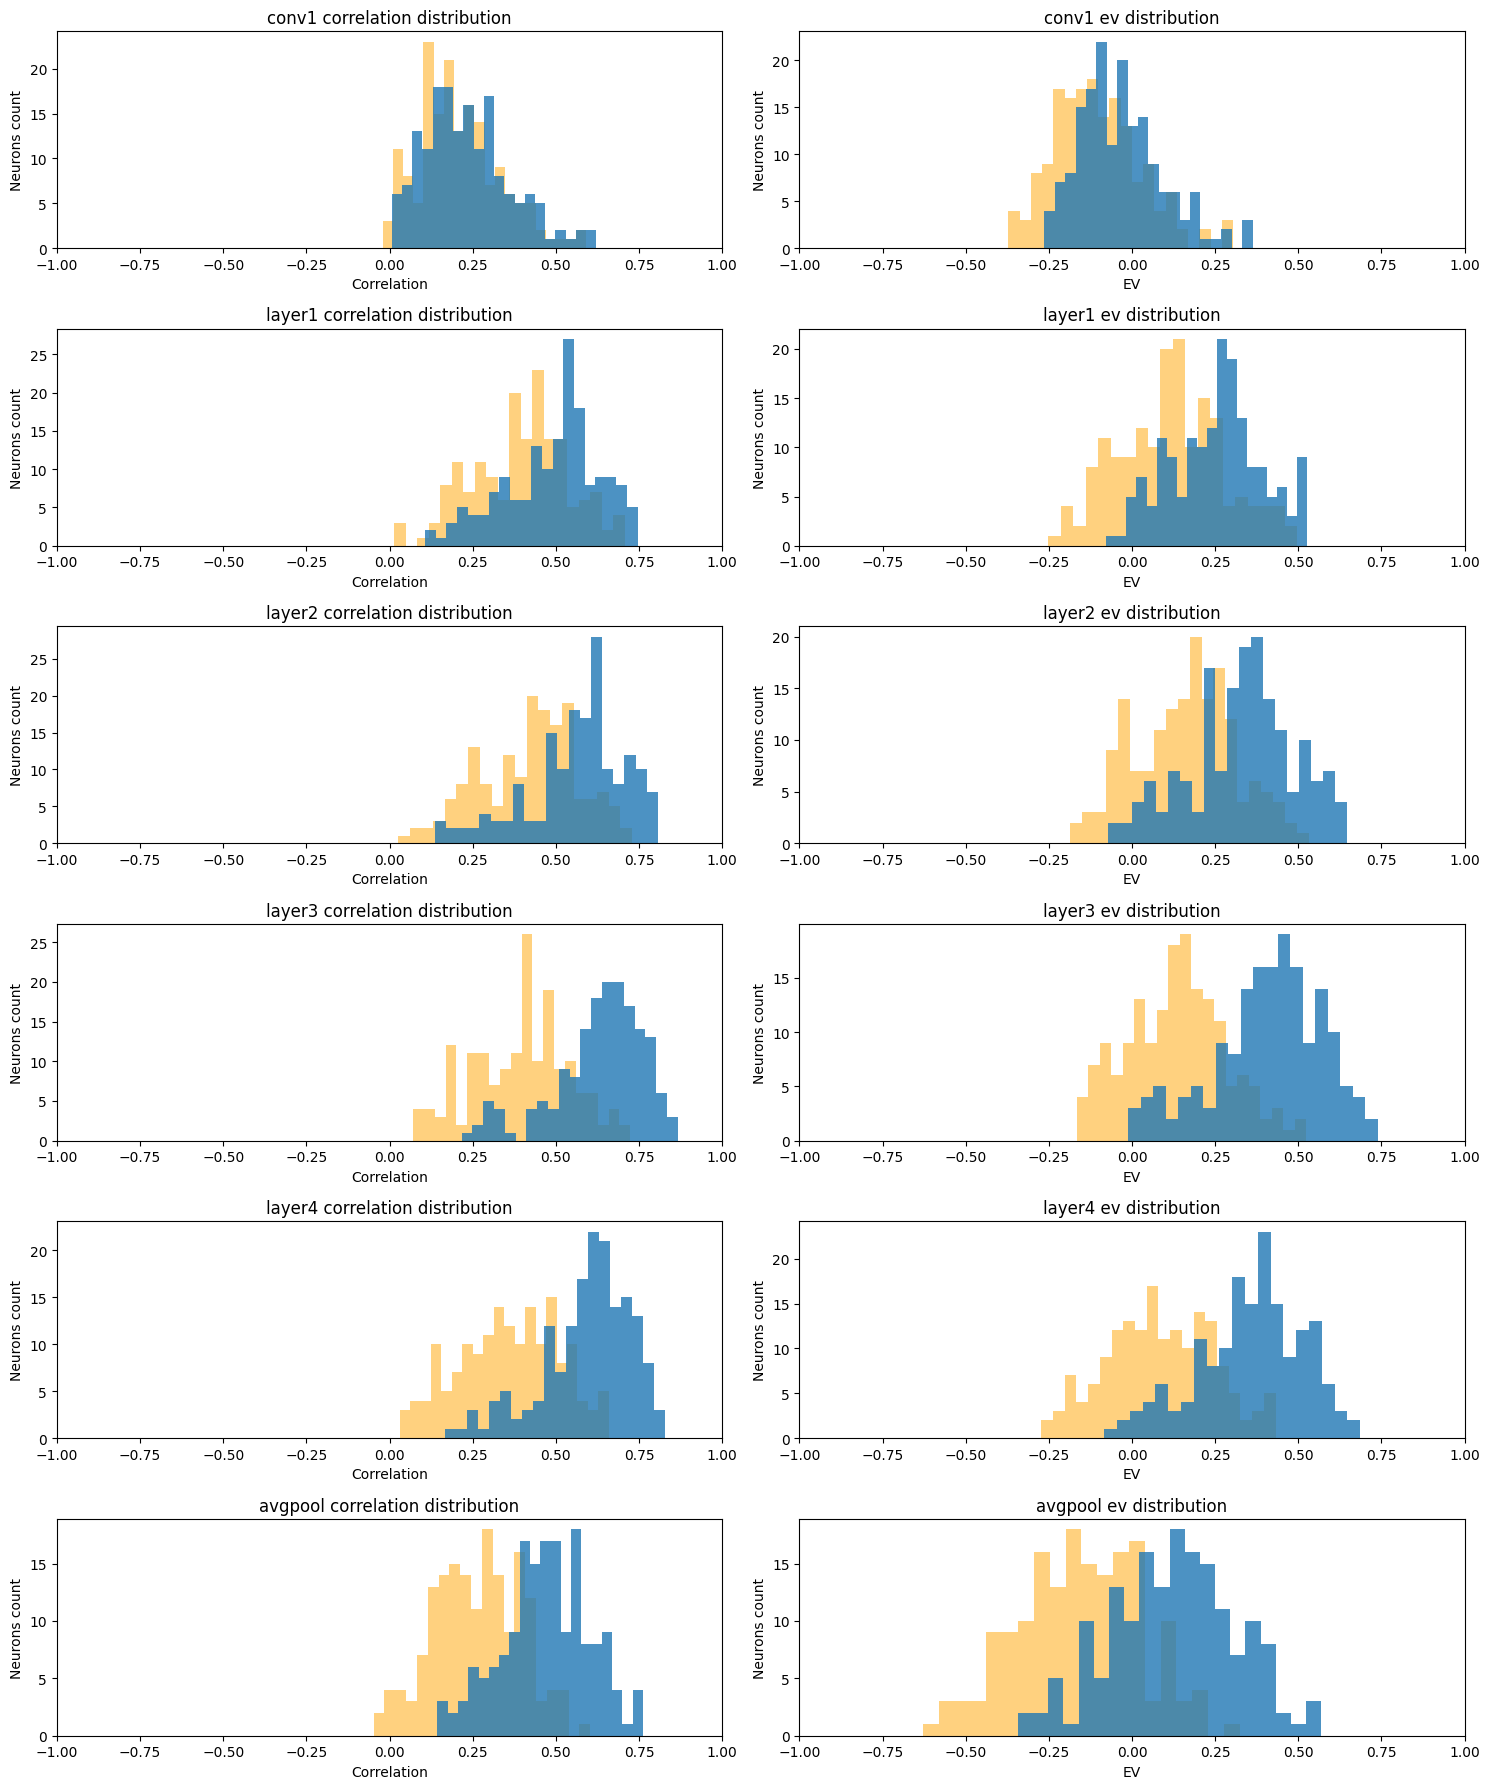

In [5]:
f, axs = plt.subplots(6,2, figsize=(15,18))

for i in range(len(return_nodes)):

    reg = Ridge()
    reg.fit(activations_tr[i], spikes_train)
    y_pred = reg.predict(activations_val[i])

    random_reg = Ridge()
    random_reg.fit(random_activations_tr[i], spikes_train)
    random_y_pred = random_reg.predict(random_activations_val[i])

    ev_scores = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    corr_scores = [np.corrcoef(spikes_val[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])]

    random_ev_scores = explained_variance_score(spikes_val, random_y_pred, multioutput='raw_values')
    random_corr_scores = [np.corrcoef(spikes_val[:,neuron], random_y_pred[:,neuron])[0,1] for neuron in range(random_y_pred.shape[1])]

    axs[i,0].set_title(f'{return_nodes[i]} correlation distribution')
    axs[i,0].hist(random_corr_scores, bins=20, alpha=0.5, color='orange')
    axs[i,0].hist(corr_scores, bins=20, alpha=0.8)
    axs[i,0].set_xlabel('Correlation')
    axs[i,0].set_ylabel('Neurons count')
    axs[i,0].set_xlim((-1, 1))

    axs[i,1].set_title(f'{return_nodes[i]} ev distribution')
    axs[i,1].hist(random_ev_scores, bins=20, alpha=0.5, color='orange')
    axs[i,1].hist(ev_scores, bins=20, alpha=0.8)
    axs[i,1].set_xlabel('EV')
    axs[i,1].set_ylabel('Neurons count')
    axs[i,1].set_xlim((-1, 1))

plt.tight_layout()
plt.show()